<a href="https://colab.research.google.com/github/dan-kwon/computer-vision/blob/main/unet_architecture/example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations

  Cloning https://github.com/albumentations-team/albumentations to /private/var/folders/kc/22nrcfyj26bfczb8g410jks40000gn/T/pip-req-build-c1valqlo
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /private/var/folders/kc/22nrcfyj26bfczb8g410jks40000gn/T/pip-req-build-c1valqlo
  Resolved https://github.com/albumentations-team/albumentations to commit fb81e6c9e378df23bf7570b7dbbd421639ab4984
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
#!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 20.97 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [2]:
import sys
sys.path.append('/data')

import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import u_net.helper

## Set up configurations

In [9]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cpu'

EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [5]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [6]:
row = df.iloc[21]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255.0

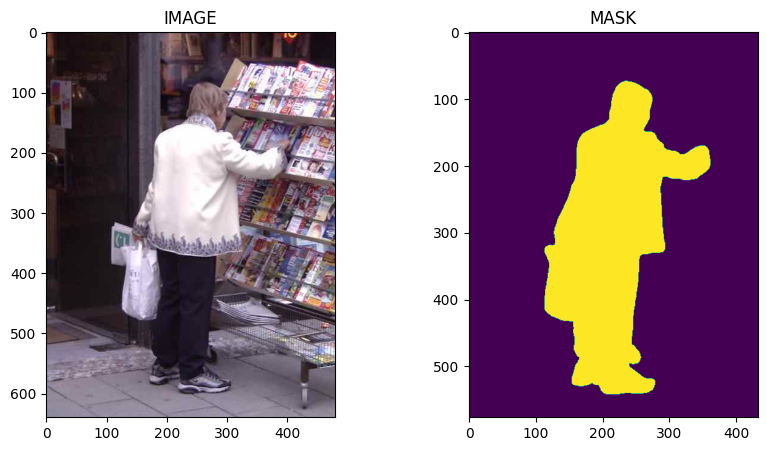

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('MASK')
ax2.imshow(mask)

In [8]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

## Augmenting Functions

In [9]:
import albumentations as A

In [10]:
def get_train_augs():
  result = A.Compose(
      [
          A.Resize(IMAGE_SIZE, IMAGE_SIZE),
          A.HorizontalFlip(p=0.5),
          A.VerticalFlip(p=0.5)
      ],
      is_check_shapes=False
  )
  return result

def get_valid_augs():
  result = A.Compose(
      [
          A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      ],
      is_check_shapes=False
  )
  return result

## Creating a custom dataset

In [11]:
from torch.utils.data import Dataset

In [12]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # (h, w, c)
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

    # (h, w, c) -> (c, h, w)

    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [13]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [14]:
print(f"Size of Trainset: {len(trainset)}")
print(f"Size of Validset: {len(validset)}")

Size of Trainset: 232
Size of Validset: 58


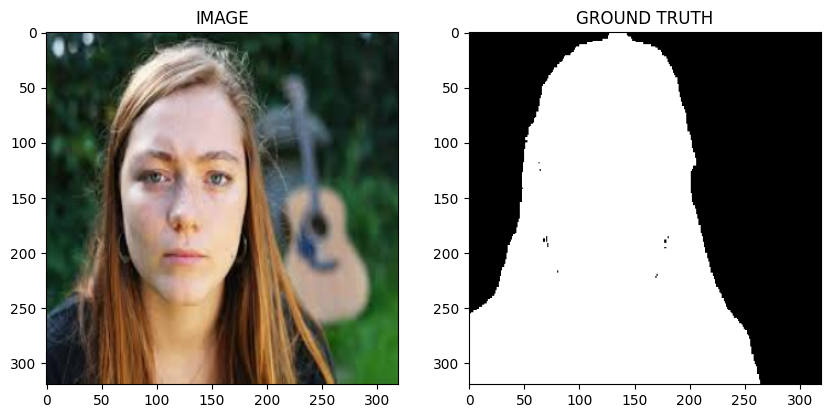

In [15]:
idx = 0
image, mask = trainset[idx]
helper.show_image(image, mask)

## Load dataset into batches

In [16]:
from torch.utils.data import DataLoader

In [17]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [18]:
print(f"total number of batches in trainloader : {len(trainloader)}")
print(f"total number of batches in validloader : {len(validloader)}")

total number of batches in trainloader : 15
total number of batches in validloader : 4


In [19]:
for image, mask in trainloader:
  break

print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


## Create segmentation model

In [20]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [31]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()
    self.arc = smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=WEIGHTS,
        in_channels=3,
        classes=1,
        activation=None
    )

  def forward(self, images, masks=None):
    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1+loss2

    return logits

In [32]:
model = SegmentationModel()
model.to(DEVICE);

## Creating Train and Validation Functions

In [33]:
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [37]:
def eval_fn(data_loader, model):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)
      total_loss += loss.item()

  return total_loss / len(data_loader)

## Train Model

In [35]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [39]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("SAVED MODEL")
    best_valid_loss = valid_loss

  print(f"Epoch: {i+1} Train_loss: {train_loss} Valid_loss: {valid_loss}")

100%|██████████| 4/4 [00:00<00:00,  5.03it/s]


SAVED MODEL
Epoch: 1 Train_loss: 0.2873978724082311 Valid_loss: 0.41517505049705505


100%|██████████| 4/4 [00:01<00:00,  3.75it/s]


SAVED MODEL
Epoch: 2 Train_loss: 0.2655710866053899 Valid_loss: 0.2825522758066654


100%|██████████| 4/4 [00:00<00:00,  4.94it/s]


SAVED MODEL
Epoch: 3 Train_loss: 0.228521728515625 Valid_loss: 0.21582087129354477


100%|██████████| 4/4 [00:00<00:00,  4.99it/s]


Epoch: 4 Train_loss: 0.20340082049369812 Valid_loss: 0.2647720016539097


100%|██████████| 4/4 [00:00<00:00,  5.08it/s]


SAVED MODEL
Epoch: 5 Train_loss: 0.1928484708070755 Valid_loss: 0.207294549793005


100%|██████████| 4/4 [00:00<00:00,  4.97it/s]


Epoch: 6 Train_loss: 0.231829438606898 Valid_loss: 0.24238766357302666


100%|██████████| 4/4 [00:00<00:00,  4.38it/s]


Epoch: 7 Train_loss: 0.22675460080305734 Valid_loss: 0.2602839842438698


100%|██████████| 4/4 [00:02<00:00,  1.66it/s]


Epoch: 8 Train_loss: 0.18624092737833658 Valid_loss: 0.2627926431596279


100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


Epoch: 9 Train_loss: 0.174886487921079 Valid_loss: 0.45513181388378143


100%|██████████| 4/4 [00:00<00:00,  4.06it/s]


Epoch: 10 Train_loss: 0.21882943560679755 Valid_loss: 0.3211631141602993


100%|██████████| 4/4 [00:01<00:00,  3.20it/s]


Epoch: 11 Train_loss: 0.15089350938796997 Valid_loss: 0.3303440064191818


100%|██████████| 4/4 [00:00<00:00,  5.06it/s]


Epoch: 12 Train_loss: 0.1371298943956693 Valid_loss: 0.22680454701185226


100%|██████████| 4/4 [00:00<00:00,  4.28it/s]


SAVED MODEL
Epoch: 13 Train_loss: 0.13564757059017818 Valid_loss: 0.1925339251756668


100%|██████████| 4/4 [00:01<00:00,  3.66it/s]


Epoch: 14 Train_loss: 0.19200032899777095 Valid_loss: 0.19594233855605125


100%|██████████| 4/4 [00:00<00:00,  4.37it/s]


SAVED MODEL
Epoch: 15 Train_loss: 0.14444189469019572 Valid_loss: 0.19047821685671806


100%|██████████| 4/4 [00:00<00:00,  4.67it/s]


Epoch: 16 Train_loss: 0.1272087052464485 Valid_loss: 0.19666797295212746


100%|██████████| 4/4 [00:01<00:00,  3.05it/s]


SAVED MODEL
Epoch: 17 Train_loss: 0.1431105981270472 Valid_loss: 0.18416821956634521


100%|██████████| 4/4 [00:00<00:00,  4.50it/s]


Epoch: 18 Train_loss: 0.12433404425779979 Valid_loss: 0.20888814330101013


100%|██████████| 4/4 [00:00<00:00,  4.99it/s]


SAVED MODEL
Epoch: 19 Train_loss: 0.11279913634061814 Valid_loss: 0.17750240489840508


100%|██████████| 4/4 [00:00<00:00,  4.67it/s]


SAVED MODEL
Epoch: 20 Train_loss: 0.10835199952125549 Valid_loss: 0.1769632175564766


100%|██████████| 4/4 [00:00<00:00,  4.24it/s]


SAVED MODEL
Epoch: 21 Train_loss: 0.09700258672237397 Valid_loss: 0.15818010084331036


100%|██████████| 4/4 [00:00<00:00,  5.01it/s]


Epoch: 22 Train_loss: 0.09382249017556508 Valid_loss: 0.17219441942870617


100%|██████████| 4/4 [00:00<00:00,  4.94it/s]


Epoch: 23 Train_loss: 0.07951617886622747 Valid_loss: 0.17087602242827415


100%|██████████| 4/4 [00:01<00:00,  3.83it/s]


Epoch: 24 Train_loss: 0.07899182885885239 Valid_loss: 0.18359660357236862


100%|██████████| 4/4 [00:00<00:00,  4.94it/s]

Epoch: 25 Train_loss: 0.0718280591070652 Valid_loss: 0.1590046938508749


## Inference

In [49]:
idx = 21

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (c, h, w) -> (1, c, h, w)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

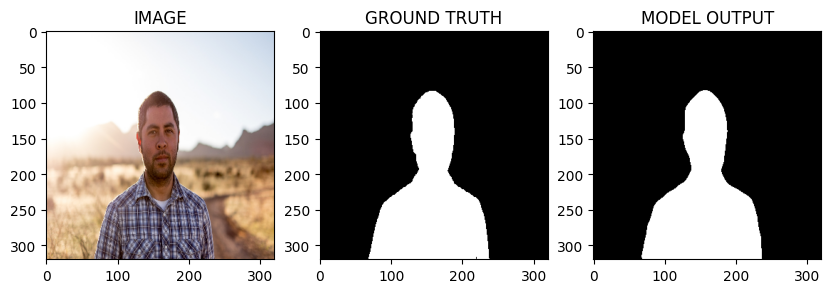

In [50]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))